In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import scipy
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.metrics import pairwise_distances
# import text_similarity

train_data = fetch_20newsgroups(subset='train')
train_X = train_data['data']
train_Y = train_data['target']
print ("Done loading train data")

test_data = fetch_20newsgroups(subset='test')
test_X = test_data['data']
test_Y = test_data['target']
print ("Done loading test data")

data_X = train_X + test_X

Done loading train data
Done loading test data


In [5]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_X)
vectors = list(vectors)
print(type(vectors))
print(type(vectors[0]))
print(len(vectors))
# print(type(np.array(vectors)))

print("Done Loading files as train and test")

<class 'list'>
<class 'scipy.sparse.csr.csr_matrix'>
18846
Done Loading files as train and test


In [6]:
train_data = []
train_labels = list(train_Y) + list(test_Y)
for i in range(len(vectors)):
    train_data.append([train_labels[i], vectors[i]])
print("Done creating train data")
print(train_data[0])
print(type(train_data[0]))
print(type(train_data[0][1]))
print(type(train_data[0][0]))

Done creating train data
[7, <1x173762 sparse matrix of type '<class 'numpy.float64'>'
	with 89 stored elements in Compressed Sparse Row format>]
<class 'list'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.int32'>


In [7]:
training_size = int(len(list(train_data))*0.10)
print(training_size)
print(type(train_data))
validation = train_data[:training_size]
training = train_data[training_size:]

print(len(training))
print(len(validation))

print("Done creating training and validation sets")

1884
<class 'list'>
16962
1884
Done creating training and validation sets


In [8]:
print(type(training))
print(type(training[0]))
print(type(training[0][1]))
print(type(training[0][0]))

<class 'list'>
<class 'list'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.int32'>


In [9]:
import random
def init_centroids(labelled_data,k):
    print("Generating Centroids")
    cen = list(map(lambda x: x[1], random.sample(labelled_data,k)))
#     print (type(cen[0]))
    s = cen[0]
    for i in range(1, len(cen)):
        s = s + cen[i]
    return cen
k = 10

In [10]:
from sklearn.metrics.pairwise import euclidean_distances

def form_clusters(labelled_data, unlabelled_centroids):
    print("Forming Clusters")
    centroids_indices = range(len(unlabelled_centroids))
    clusters = [[] for i in centroids_indices]
    i = 0 
    for (label,Xi) in labelled_data:
#         print(i)
        i += 1
        smallest_distance = float("inf")
        for cj_index in centroids_indices:
            cj = unlabelled_centroids[cj_index]
            distance = euclidean_distances(Xi, cj)
            if distance < smallest_distance:
                closest_centroid_index = cj_index
                smallest_distance = distance
        
        clusters[closest_centroid_index].append([label,Xi])
    print ("Done Creating Clusters")
    print("--------------------")
    
    return clusters

# f = form_clusters(training, c)

In [11]:
def move_centroids(clusters):
    new_centroids = []
#     print("The labelled_clusters type: ", type(clusters))
#     print(len(clusters))
    print("At move_centroids")
    for i in range(len(clusters)):
#         print("i=", i)
        s = clusters[i][0][1]
        for j in range(1, len(clusters[i])):
#             print("j=", j)
        
            s += clusters[i][j][1]

        new_centroids.append(s/len(clusters[i]))
    print("Done moving centroids")
    return new_centroids

# c2 = move_centroids(f)


In [12]:
from sklearn.metrics.pairwise import euclidean_distances

def repeat_until_convergence(labelled_data, labelled_clusters, centroids):
    previous_max_difference = 100000
    iter = 0
    max_iter = 10
    while iter < max_iter:
        iter += 1
        print ("Updating centroids, iteration: ", iter)
        unlabelled_old_centroids = centroids
        centroids = move_centroids(labelled_clusters)
        labelled_clusters = form_clusters(labelled_data, centroids)
        # keep old_clusters and clusters so we can get the maximum difference
        # between centroid positions every time.
        differences = map(lambda a, b: euclidean_distances(a,b),unlabelled_old_centroids,centroids)
        max_difference = max(differences)
        print("max difference: ", max_difference)
        print("-----------------------------------")
        difference_change = abs((max_difference-previous_max_difference)/np.mean([previous_max_difference,max_difference])) * 100
        previous_max_difference = max_difference
        if np.isnan(difference_change):
            break
    return labelled_clusters, centroids

In [13]:
def cluster(labelled_data, k):
    print("Beginning the clustering procedure")
    centroids = init_centroids(labelled_data, k)
    clusters = form_clusters(labelled_data, centroids)
    print("======================")
#     print(type(clusters[0]))
    final_clusters, final_centroids = repeat_until_convergence(labelled_data, clusters, centroids)
    print ("Exiting cluster function")
    return final_clusters, final_centroids

In [14]:
import itertools
import operator

def most_common(L):
    SL = sorted((x, i) for i, x in enumerate(L))
    groups = itertools.groupby(SL, key=operator.itemgetter(0))
    def _auxfun(g):
        item, iterable = g
        count = 0
        min_index = len(L)
        for _, where in iterable:
            count += 1
            min_index = min(min_index, where)
        return count, -min_index
    return max(groups, key=_auxfun)[0]


In [15]:
def assign_labels_to_centroids(clusters, centroids):
    labelled_centroids = []
    clusters = list(clusters)
    for i in range(len(clusters)):
        labels = []
        for k in clusters[i]:
            labels.append(k[0])
        common = most_common(labels)
        centroid = (common, centroids[i])
        labelled_centroids.append(centroid)
    return labelled_centroids

In [16]:
def classify_file(file, labelled_centroids):
    mindistance = float("inf")
    for (label, centroid) in labelled_centroids:
        distance = euclidean_distances(centroid, file)
        if distance < mindistance:
            mindistance = distance
            closest_centroid_label = label
    return closest_centroid_label

In [21]:
def get_dict(cluster):
    d = dict()
    for j in range(len(cluster)):
        label = cluster[j][0]
        if label in d:
            d[label] += 1
        else:
            d[label] = 1
#     print(d)
    return d

In [17]:
def get_purity(clusters):
    size = []
    purity = []
    for cluster in clusters:
        d = get_dict(cluster)
        l = len(cluster)
        size.append(l)
        purity.append(max(list(d.values())))
    return sum(purity)/len(training)

In [18]:
def get_error_rate(labelled_files,labelled_centroids):
    classified_incorrect = 0
    for (label,file) in labelled_files:
        classified_label = classify_file(file, labelled_centroids)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(train_data))
    return error_rate

In [23]:
def kmeans(k):
    clusters, centroids = cluster(training, k)
    purity = get_purity(clusters)
    print(purity)
    labelled_centroids = assign_labels_to_centroids(clusters, centroids)
    error_rate = get_error_rate(validation, labelled_centroids)
    return error_rate

In [88]:
all_k = [5, 10, 20, 100]
error_rates = [kmeans(i) for i in all_k]

print(error_rates)

x_axis = all_k
y_axis = error_rates
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()

Beginning the clustering procedure
Generating Centroids
Forming Clusters
Done Creating Clusters
--------------------
Updating centroids, iteration:  1
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.95400931]]
-----------------------------------
Updating centroids, iteration:  2
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.08073927]]
-----------------------------------
Updating centroids, iteration:  3
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.05416192]]
-----------------------------------
Updating centroids, iteration:  4
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.0320115]]
-----------------------------------
Updating centroids, iteration:  5
At move_centroids
Done moving cent

Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.06770642]]
-----------------------------------
Updating centroids, iteration:  9
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.0991739]]
-----------------------------------
Updating centroids, iteration:  10
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.13409233]]
-----------------------------------
Exiting cluster function
[0.08861296826912873, 0.08118433619866285, 0.08192719940570943, 0.06844953836357848]


NameError: name 'plt' is not defined

In [89]:
error_rates

[0.08861296826912873,
 0.08118433619866285,
 0.08192719940570943,
 0.06844953836357848]

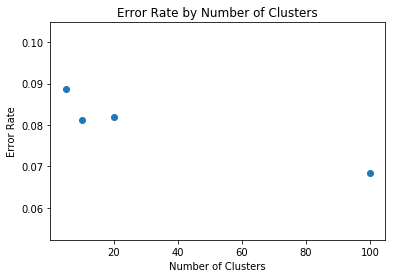

In [90]:
import matplotlib.pyplot as plt

x_axis = all_k
y_axis = error_rates
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()

In [20]:
kmeans(20)

Beginning the clustering procedure
Generating Centroids
Forming Clusters
Done Creating Clusters
--------------------
Updating centroids, iteration:  1
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.94857524]]
-----------------------------------
Updating centroids, iteration:  2
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.10571992]]
-----------------------------------
Updating centroids, iteration:  3
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.0957584]]
-----------------------------------
Updating centroids, iteration:  4
At move_centroids
Done moving centroids
Forming Clusters
Done Creating Clusters
--------------------
max difference:  [[ 0.0850082]]
-----------------------------------
Updating centroids, iteration:  5
At move_centroids
Done moving centr

NameError: name 'get_dict' is not defined